In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Cargar el dataset procesado que guardamos antes
df = pd.read_csv('../data/processed/df_betania.csv')

In [ ]:
df["Reason no cancer-directed surgery"].unique()

array(['Surgery performed', 'Not recommended', 'Refused'], dtype=object)

In [ ]:
df.drop(columns=['Race','Sex', 'Combined Summary Stage with Expanded Regional Codes (2004+)',
                 'histology_type_named'], inplace=True)  
                 

--- ENTRENAMIENTO CON FILTRO DINÁMICO POR HITO ---


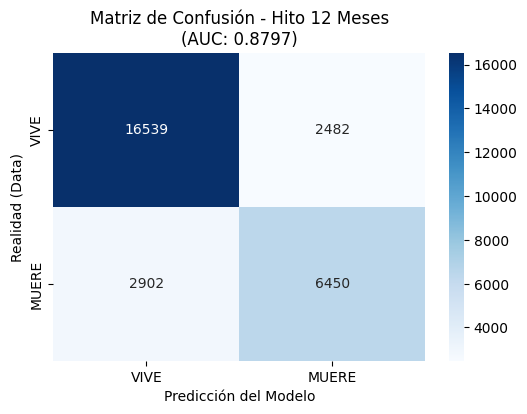

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     19021
           1       0.72      0.69      0.71      9352

    accuracy                           0.81     28373
   macro avg       0.79      0.78      0.78     28373
weighted avg       0.81      0.81      0.81     28373



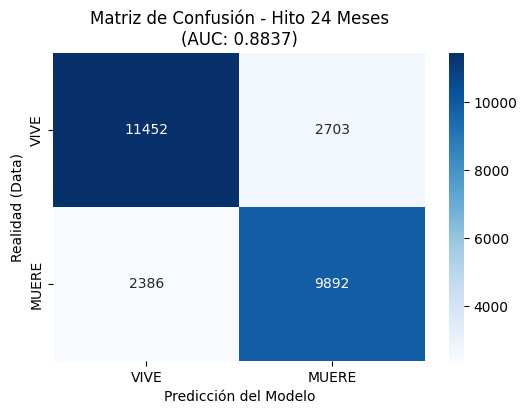

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     14155
           1       0.79      0.81      0.80     12278

    accuracy                           0.81     26433
   macro avg       0.81      0.81      0.81     26433
weighted avg       0.81      0.81      0.81     26433



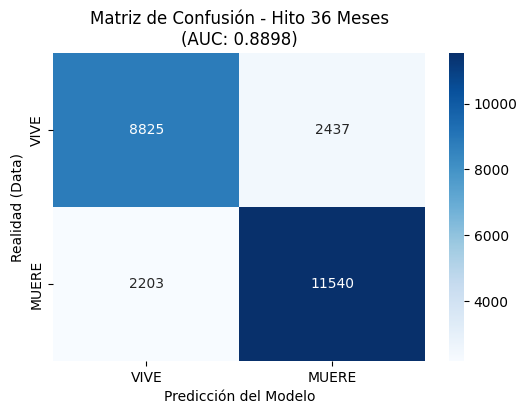

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     11262
           1       0.83      0.84      0.83     13743

    accuracy                           0.81     25005
   macro avg       0.81      0.81      0.81     25005
weighted avg       0.81      0.81      0.81     25005



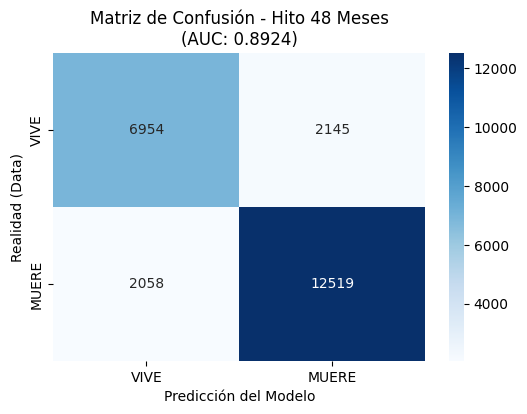

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      9099
           1       0.85      0.86      0.86     14577

    accuracy                           0.82     23676
   macro avg       0.81      0.81      0.81     23676
weighted avg       0.82      0.82      0.82     23676



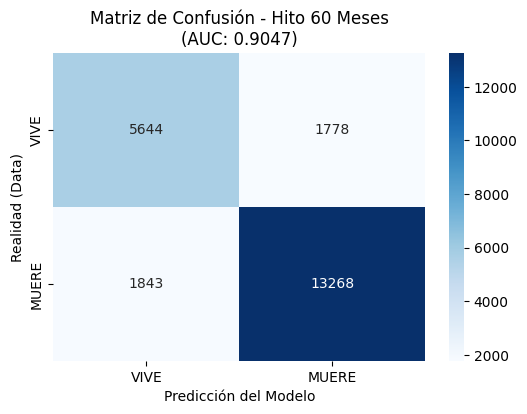

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      7422
           1       0.88      0.88      0.88     15111

    accuracy                           0.84     22533
   macro avg       0.82      0.82      0.82     22533
weighted avg       0.84      0.84      0.84     22533

--------------------------------------------------
--- TODOS LOS MODELOS ENTRENADOS Y GUARDADOS ---


In [ ]:

# --- DEFINICIÓN DE COLUMNAS (Aquí es donde se declaran) ---
# Usamos las que mencionaste en tus mensajes anteriores
num_features = [
    'age_group', 
    'tumor_category', 
    'grade_clinical', 
    'income_level',
    'Total number of in situ/malignant tumors for patient'
]

cat_features = [
    #'Race',
    #'Rural Code',
    'tratamiento',
   #'Reason no cancer-directed surgery',
   #'Chemotherapy recode (yes, no/unk)',
   #'Radiation recode',
    'Primary Site',
    'Stage_Final',
    #'surgery_class'
]

cortes = [12, 24, 36, 48, 60]
modelos_finales = {}

from sklearn.metrics import confusion_matrix, classification_report
import joblib

print("--- ENTRENAMIENTO CON FILTRO DINÁMICO POR HITO ---")

for meses in cortes:
    # 1. FILTRADO ESPECÍFICO PARA ESTE HITO
    condicion_muerte = (df['target_cancer_death'] == 1)
    condicion_vivo_suficiente = (df['target_cancer_death'] == 0) & (df['survival_months_int'] >= meses)
    
    df_hito = df[condicion_muerte | condicion_vivo_suficiente].copy()
    
    # 2. DEFINIR EL TARGET
    target_col = f'target_{meses}_m'
    df_hito[target_col] = np.where(
        (df_hito['target_cancer_death'] == 1) & (df_hito['survival_months_int'] <= meses), 1, 0
    )
    
    # 3. SELECCIÓN DE CARACTERÍSTICAS Y SPLIT
    X = df_hito[num_features + cat_features]
    y = df_hito[target_col]
    
    # Es recomendable usar stratify=y para mantener la proporción de muertes en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Definición del preprocessor dentro del bucle para asegurar limpieza
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features)
        ])

    # 4. PIPELINE
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(n_estimators=120, learning_rate=0.1, max_depth=5, subsample=0.8, random_state=42))
    ])
    
    # Entrenamiento
    pipeline.fit(X_train, y_train)
    
    # 5. EVALUACIÓN
   # 5. EVALUACIÓN Y GRÁFICO "BONITO"
    y_pred = pipeline.predict(X_test)
    auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    cm = confusion_matrix(y_test, y_pred)

    # --- Generar el Heatmap de Seaborn ---
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['VIVE', 'MUERE'], 
                yticklabels=['VIVE', 'MUERE'])
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Realidad (Data)')
    plt.title(f'Matriz de Confusión - Hito {meses} Meses\n(AUC: {auc:.4f})')
    plt.show()
    
    # Opcional: Imprime también precisión y sensibilidad
    print(classification_report(y_test, y_pred)) 
    
    # Guardar cada pipeline por separado
    joblib.dump(pipeline, f'pipeline_{meses}m.pkl')

print("-" * 50)
print("--- TODOS LOS MODELOS ENTRENADOS Y GUARDADOS ---")


--- PREDICCIÓN PARA PACIENTE NUEVO ---
Riesgo de mortalidad a los 12 meses: 8.9%
Riesgo de mortalidad a los 24 meses: 30.0%
Riesgo de mortalidad a los 36 meses: 32.6%
Riesgo de mortalidad a los 48 meses: 58.3%
Riesgo de mortalidad a los 60 meses: 66.4%


c:\Users\Usuario\miniconda3\envs\env_312project\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\Usuario\miniconda3\envs\env_312project\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\Usuario\miniconda3\envs\env_312project\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\Usuario\miniconda3\envs\env_312project\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories wil

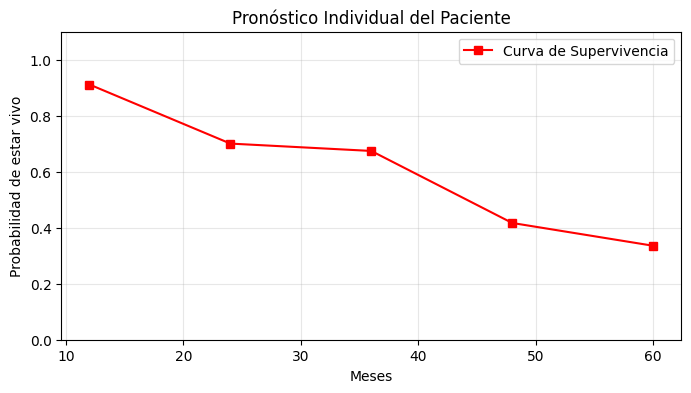

In [ ]:
# --- PARTE B: PREDICCIÓN PACIENTE NUEVO ---
print("\n--- PREDICCIÓN PARA PACIENTE NUEVO ---")




# Define aquí los valores de tu paciente (asegúrate que los nombres coincidan)
nuevo_paciente = {
    'age_group': 2,
    'tumor_category': 10.0, # mm
    'grade_clinical': 1,
    'income_level': 5,
    'Total number of in situ/malignant tumors for patient': 1,
    'tratamiento': 'S + Q + nR',
    'Primary Site': 'C34.3-Lower lobe, lung',
    'Stage_Final': 4
}

df_nuevo = pd.DataFrame([nuevo_paciente])
probabilidades = []

for meses in cortes:
    pipeline = joblib.load(f'pipeline_{meses}m.pkl')
    prob_muerte = pipeline.predict_proba(df_nuevo)[0][1]
    probabilidades.append(prob_muerte)
    print(f"Riesgo de mortalidad a los {meses} meses: {prob_muerte:.1%}")

# Graficar la curva resultante para el paciente
supervivencia = [1 - p for p in probabilidades]
plt.figure(figsize=(8, 4))
plt.plot(cortes, supervivencia, marker='s', color='red', label='Curva de Supervivencia')
plt.ylim(0, 1.1)
plt.title("Pronóstico Individual del Paciente")
plt.xlabel("Meses")
plt.ylabel("Probabilidad de estar vivo")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

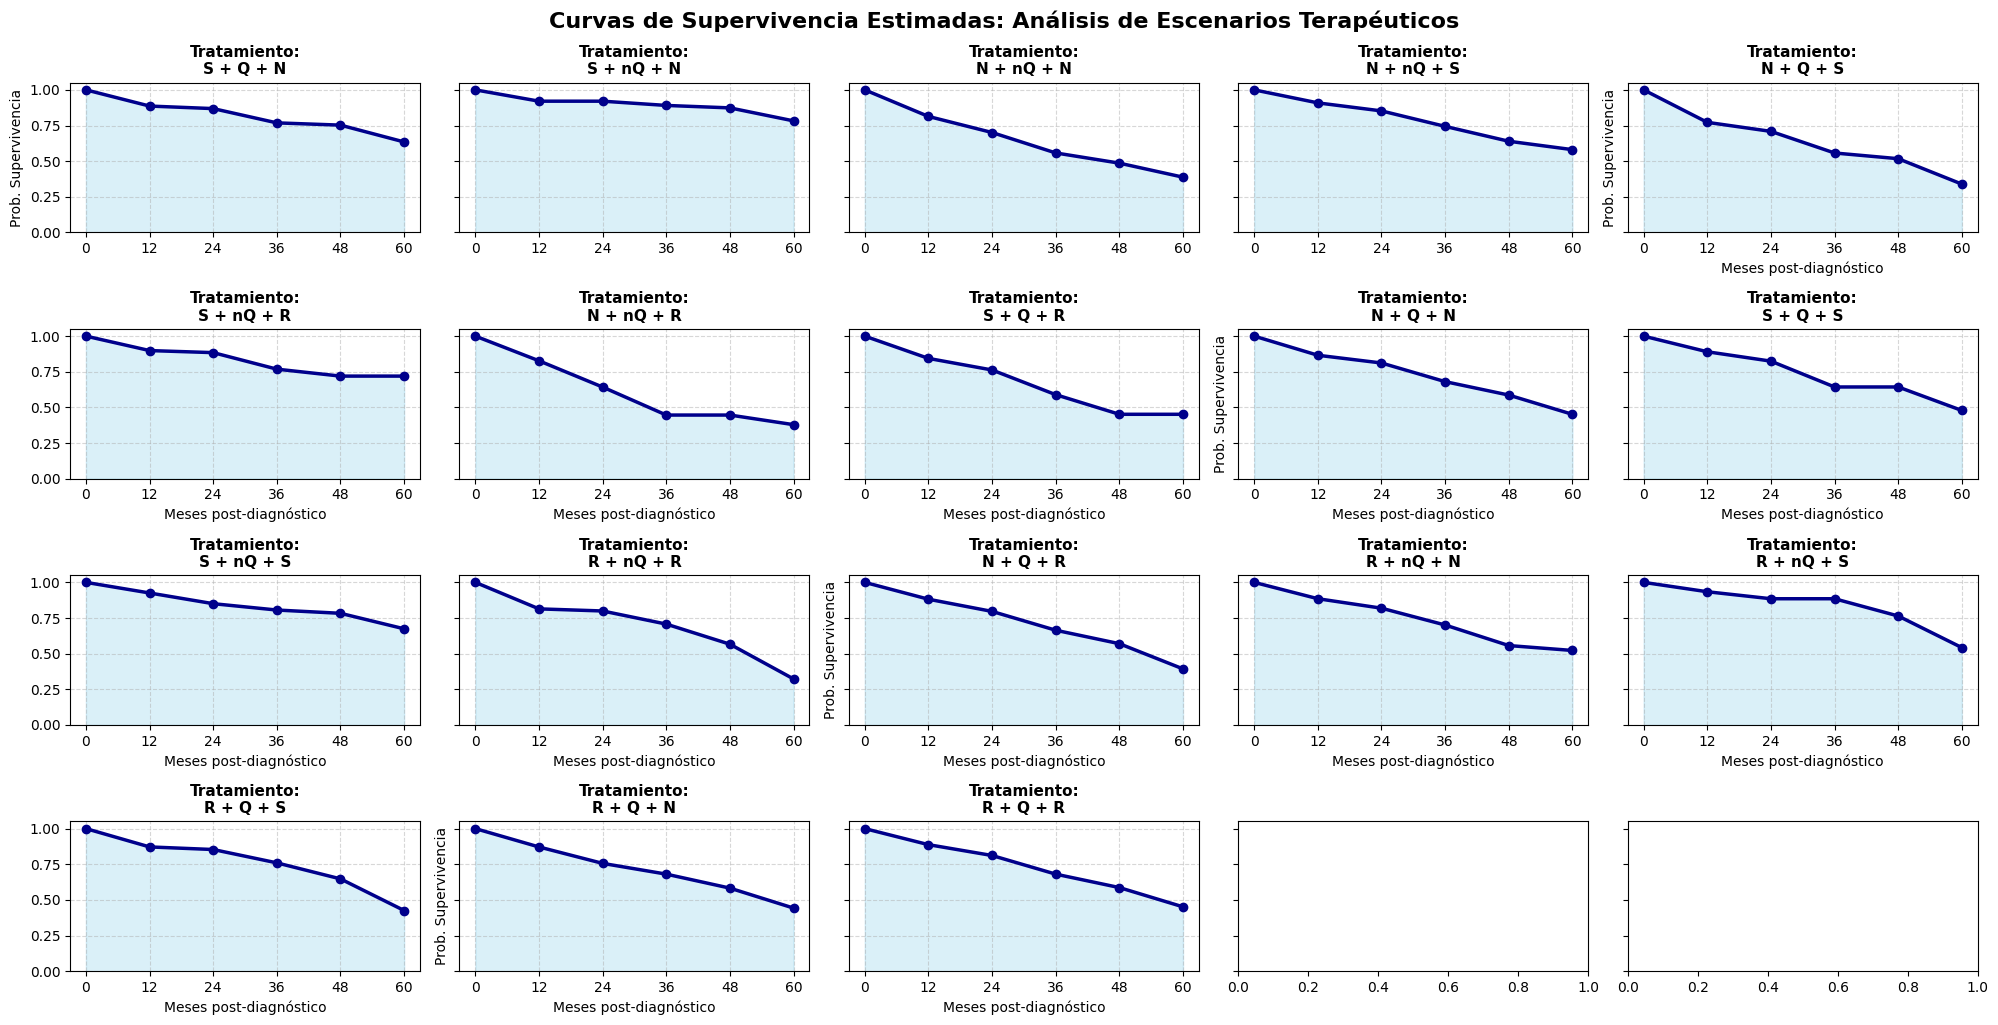

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# 1. Definir las combinaciones de tratamiento
combinaciones_trat = df["tratamiento"].unique()

# 2. Datos base del paciente (sin el tratamiento)
paciente_base = {
    'age_group': 6,
    'tumor_category': 10.0, 
    'grade_clinical': 1,
    'income_level': 5,
    'Total number of in situ/malignant tumors for patient': 3,
    'Primary Site': 'C34.3-Lower lobe, lung',
    'Stage_Final': 2
}

cortes_grafico = [0, 12, 24, 36, 48, 60]
cortes_modelos = [12, 24, 36, 48, 60]

#2. Cargar modelos
modelos = {m: joblib.load(f'pipeline_{m}m.pkl') for m in cortes_modelos}

# 3. Crear la figura (2 filas, 4 columnas)
fig, axes = plt.subplots(4, 5, figsize=(20, 10), sharey=True)
axes = axes.flatten()

for i, trat in enumerate(combinaciones_trat):
    datos_escenario = paciente_base.copy()
    datos_escenario['tratamiento'] = trat
    df_escenario = pd.DataFrame([datos_escenario])
    
    # Iniciamos con 1.0 (100%) para el mes 0
    supervivencia = [1.0]
    ultimo_riesgo = 0.0 # El riesgo empieza en 0
    
    for m in cortes_modelos:
        # Predicción del modelo para el hito m
        p = modelos[m].predict_proba(df_escenario)[0][1]
        
        # CORRECCIÓN MONÓTONA: El riesgo no puede bajar respecto al mes anterior
        if p < ultimo_riesgo:
            p = ultimo_riesgo
        
        supervivencia.append(1 - p)
        ultimo_riesgo = p # Actualizamos para el siguiente mes
    
    # Graficar
    ax = axes[i]
    ax.plot(cortes_grafico, supervivencia, marker='o', linewidth=2.5, color='darkblue', label='Supervivencia')
    ax.fill_between(cortes_grafico, supervivencia, color='skyblue', alpha=0.3)
    
    # Estética y Ejes
    ax.set_title(f"Tratamiento:\n{trat}", fontsize=11, fontweight='bold')
    ax.set_xticks(cortes_grafico) # Forzamos que se vean los meses 0, 12, 24...
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    if i >= 4: ax.set_xlabel("Meses post-diagnóstico")
    if i % 4 == 0: ax.set_ylabel("Prob. Supervivencia")

plt.tight_layout()
plt.suptitle("Curvas de Supervivencia Estimadas: Análisis de Escenarios Terapéuticos", 
             fontsize=16, y=1.02, fontweight='bold')
plt.show()